In [56]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import skew, kurtosis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Data Preparation

In [2]:
df1 = pd.read_csv("Dataset1_TranscriptMahasiswa.csv", sep=";", dtype={"NIM" :"object", "NAMA_MK" : "string"})
df2 = pd.read_csv("Dataset2_EvaluasiDosenPerMK.csv", sep=";", decimal=",")

## Df1 -> Df3

In [3]:
df1['KODE_MK'][df1['NAMA_MK'].isnull()].unique()

# fill Nama_MK yang null

df1["NAMA_MK"] = df1["NAMA_MK"].fillna("Tugas Akhir") # Kebetulan yang null cuman SI863

# add kode MK ke Nama_MK

for i in df1.index:  
    if df1.at[i, "KODE_MK"] not in df1.at[i, "NAMA_MK"].split(" ") : 
        df1.at[i, "NAMA_MK"] = df1.at[i, "KODE_MK"] + " " + df1.at[i, "NAMA_MK"]

        indeks = ["A", "A-", "B+", "B", "B-", "C+", "C", "D", "E", "F"]
bobot = [4, 3.7, 3.3, 3.0, 2.7, 2.3, 2.0, 1.0, 0, 0]
ranges = [[100, 85], [84.99, 80], [79.99, 75], [74.99, 70], [69.99, 65], [64.99, 60], [59.99, 55], [54.99, 45], [44.99,0]]

# fill grade yang null

for i in df1.index:
    for j in ranges:
        if j[1] <= df1.at[i, "NILAI"] <= j[0]:
            df1.at[i, "GRADE"] = indeks[ranges.index(j)]

# menambah total bobot = bobot x sks

for i in df1.index:
    for j in indeks:
        if df1.at[i, "GRADE"] == j:
            df1.at[i, "BOBOT"] = bobot[indeks.index(j)]
            df1.at[i, "TOTAL_BOBOT"] = df1.at[i, "BOBOT"] * df1.at[i, "SKS"]

# fill null NILAI

df1["NILAI"] = df1["NILAI"].fillna(0)
df1[df1['NILAI'].isnull()]

# dropping duplicate MK
df1 = df1.drop_duplicates(subset=['KODE_MK', 'NIM'], keep='last')

In [4]:
# Pembuataan Dataframe dengan grouping data berdasarkan NIM
# Perhitungan SKS
df3_ = pd.DataFrame(df1.groupby(["NIM"])["SKS"].sum().reset_index())
# Perhitungan Grade
df3__ = pd.DataFrame(df1.loc[(df1["GRADE"] == "D") | (df1["GRADE"] == "E") | (df1["GRADE"] == "F")].groupby("NIM")["GRADE"].sum().reset_index())
# Perhitungan Total Bobot
df3___ = pd.DataFrame((df1.groupby("NIM")["TOTAL_BOBOT"].sum().reset_index()))
# Perhitungan jumlah semester
df3____ =  pd.DataFrame((((df1.groupby("NIM")["SEMESTER"].max() - df1.groupby("NIM")["SEMESTER"].min()) / 100).reset_index()))
# Penambahan Kolom Lulus Tepat Waktu 

# Merging Dataframe
df3 = pd.merge(df3_, df3__, how="left", on=["NIM"])
df3 = pd.merge(df3, df3___, how="left", on=["NIM"])
df3 = pd.merge(df3, df3____, how="left", on=["NIM"])
df3["GRADE"] = df3["GRADE"].fillna("")

df3.rename(columns = {"GRADE" : "FAILED_GRADE", "SKS" : "TOTAL_SKS", "SEMESTER" : "WAKTU_KULIAH"}, inplace = True)

# Perhitungan IPK
for i in df3.index:
    df3.at[i ,"IPK"] = df3.at[i, "TOTAL_BOBOT"] / df3.at[i, "TOTAL_SKS"]
    if df3.at[i, "WAKTU_KULIAH"] - int(df3.at[i, "WAKTU_KULIAH"]) != 0: 
        df3.at[i, "WAKTU_KULIAH"] = int(df3.at[i, "WAKTU_KULIAH"]) + 0.5

# Kolom :
# Hasil : TIDAK LULUS, LULUS, TEPAT WAKTU

for i in df3.index:
    if df3.at[i, "TOTAL_SKS"] >= 144 and df3.at[i, "FAILED_GRADE"] == "" and df3.at[i, "IPK"] >= 2.5:
        # if df3.at[i, "WAKTU_KULIAH"] <= 4:
        #     df3.at[i, "HASIL"] = "Lulus Tepat Waktu"
        # else: 
        #     df3.at[i, "HASIL"] = "Lulus Telat"
        df3.at[i, "HASIL"] = "Lulus"
    else:  
        df3.at[i, "HASIL"] = "Tidak Lulus"

## Df2 -> Df4

In [5]:
# nilai rata-rata dari tiap matakuliah

df4 = pd.DataFrame(df2.groupby(["TAHUN", "MATAKULIAH"])["NILAI"].mean().reset_index())
df4.rename(columns = {"NILAI" : "NILAI_RATA-RATA"}, inplace = True)


# Modelling

## Sampling and Data Splitting

In [6]:
X = df3[['TOTAL_SKS', 'IPK', 'WAKTU_KULIAH']]
y = df3['HASIL']

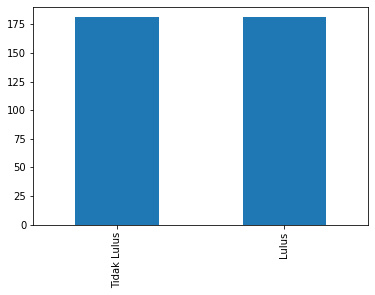

In [7]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y) 

y_rus.value_counts().plot(kind="bar")

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

## Model Evaluation

In [8]:
np.random.seed(42)

# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 0.8708994708994708 	 | cv_score_std: 0.06455026455026454
CART 	 | cv_score_mean: 0.8193121693121693 	 | cv_score_std: 0.05793650793650793
RF 	 | cv_score_mean: 0.8227513227513228 	 | cv_score_std: 0.059544382100357146
SVC 	 | cv_score_mean: 0.7710317460317461 	 | cv_score_std: 0.05744594931782841
KNN 	 | cv_score_mean: 0.8562169312169312 	 | cv_score_std: 0.018650793650793637


<AxesSubplot:>

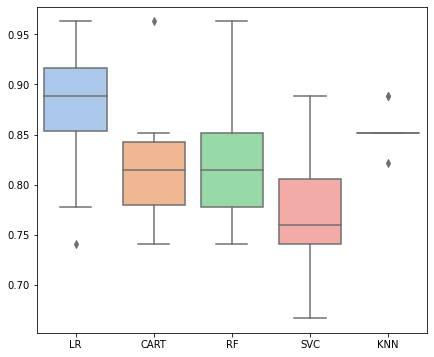

In [9]:
# boxplot comparing models
results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

# Pertanyaan Soal
1. Menemukan seberapa besar pengaruh mata kuliah yang diikuti dan atau kualitas dosen mata kulah untuk kelulusan tepat waktu mahasiswa.
2. Menemukan seberapa besar pengaruh mata kuliah yang diikuti dan atau kualitas dosen mata kulah untuk kelulusan tepat waktu mahasiswa.
3. Melakukan analisis dan faktor pengaruh kualitas dosen melalui pencapaian nilai akhir mahasiswa yang digunakan sebagai prediksi terhadap kelulusan tepat waktu mahasiswa,
4. Melakukan analisis dan menetapkan penemuan faktor-faktor yang sangat berpengaruh terhadap waktu studi mahasiswa dan kesimpulan dari prediksi pengaruh kualitas dosen terhadap kelulusan mahasiswa tepat waktu


# Modeling ketepatan waktu lulus

In [33]:
df5 = df3[df3['HASIL'] == 'Lulus'].reset_index()
df5

,index,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,HASIL
0,3,00000008631,145,,519.3,3.0,3.581379,Lulus
1,4,00000008684,145,,512.1,3.0,3.531724,Lulus
2,10,00000009139,145,,541.3,3.5,3.733103,Lulus
3,12,00000009252,145,,496.5,3.5,3.424138,Lulus
4,13,00000009253,145,,572.8,3.5,3.950345,Lulus
...,...,...,...,...,...,...,...,...
176,745,14110310069,145,,513.0,3.5,3.537931,Lulus
177,749,14110310073,145,,565.9,3.5,3.902759,Lulus
178,750,14110310074,145,,528.0,3.5,3.641379,Lulus
179,756,14110310085,145,,481.5,3.5,3.320690,Lulus


In [36]:
# menambahkan kolom jenis kelulusan

for i in range(len(df5)):
    if df5.loc[i, 'WAKTU_KULIAH'] <= 4:
        df5.loc[i, 'TIPE'] = 'Tepat Waktu'
    else:
        df5.loc[i, 'TIPE'] = 'Telat'
        
df5.sample(10)

,index,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,HASIL,TIPE
50,483,10110310070,145,,448.9,4.5,3.095862,Lulus,Telat
178,750,14110310074,145,,528.0,3.5,3.641379,Lulus,Tepat Waktu
64,504,11110310009,145,,531.1,3.0,3.662759,Lulus,Tepat Waktu
111,598,12110310055,145,,490.1,3.5,3.380000,Lulus,Tepat Waktu
171,720,14110310041,145,,470.1,4.0,3.242069,Lulus,Tepat Waktu
69,511,11110310018,145,,491.2,3.5,3.387586,Lulus,Tepat Waktu
75,522,11110310034,145,,520.0,3.5,3.586207,Lulus,Tepat Waktu
156,685,14110310004,145,,543.1,3.5,3.745517,Lulus,Tepat Waktu
84,546,11110310068,145,,511.8,3.5,3.529655,Lulus,Tepat Waktu
19,78,00000011943,145,,494.7,3.0,3.411724,Lulus,Tepat Waktu


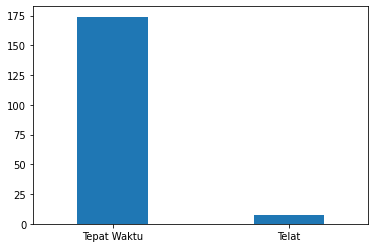

In [39]:
df5['TIPE'].value_counts().plot(kind='bar', width=0.4)
plt.xticks(rotation=0)
plt.title('Jumlah Jenis Kelulusan Mahasiswa')
plt.show()

In [41]:
X = df5[['TOTAL_SKS', 'IPK', 'WAKTU_KULIAH']]
y = df5['TIPE']

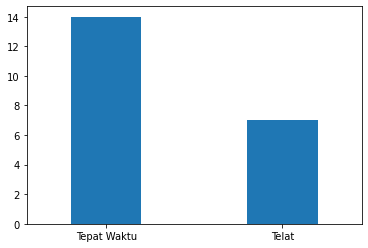

In [52]:
rus = RandomUnderSampler(sampling_strategy=0.5)
X_rus, y_rus = rus.fit_resample(X, y) 

y_rus.value_counts().plot(kind="bar", width=0.4)
plt.xticks(rotation=0)

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

In [53]:
np.random.seed(42)

# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 0.8666666666666667 	 | cv_score_std: 0.1885618083164127
CART 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
RF 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
SVC 	 | cv_score_mean: 0.7333333333333334 	 | cv_score_std: 0.09428090415820638
KNN 	 | cv_score_mean: 0.8666666666666667 	 | cv_score_std: 0.1885618083164127


<AxesSubplot:>

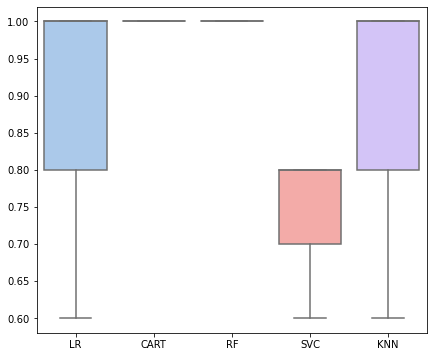

In [54]:
# boxplot comparing models
results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

# testing oversample

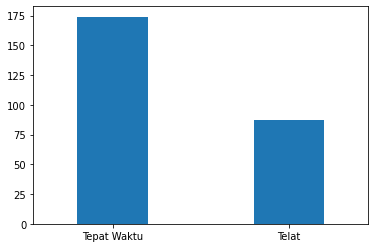

In [59]:
ov = RandomOverSampler(sampling_strategy=0.5)
X_ov, y_ov = ov.fit_resample(X, y)

y_ov.value_counts().plot(kind="bar", width=0.4)
plt.xticks(rotation=0)

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_ov, y_ov, test_size=0.25, shuffle=True, random_state=42)

In [60]:
np.random.seed(42)

# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
CART 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
RF 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
SVC 	 | cv_score_mean: 0.6461538461538462 	 | cv_score_std: 0.0
KNN 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
